In [3]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:

# lab_utils_common

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors=dlblue, lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False


def plt_tumor_data(x, y, ax):
    """ plots tumor data on one axis """
    pos = y == 1
    neg = y == 0

    ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
    ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
    ax.set_ylim(-0.175,1.1)
    ax.set_ylabel('y')
    ax.set_xlabel('Tumor Size')
    ax.set_title("Logistic Regression on Categorical Data")

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False


def sigmoid(z):
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost


In [5]:

#plt_quad_logistics

class plt_quad_logistic:
    ''' plots a quad plot showing logistic regression '''
    # pylint: disable=too-many-instance-attributes
    # pylint: disable=too-many-locals
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, x_train,y_train, w_range, b_range):
        # setup figure
        fig = plt.figure( figsize=(10,6))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.set_facecolor('#ffffff') #white
        gs  = GridSpec(2, 2, figure=fig)
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 0],  projection='3d')
        ax3 = fig.add_subplot(gs[1,1])
        pos = ax3.get_position().get_points()  ##[[lb_x,lb_y], [rt_x, rt_y]]
        h = 0.05
        width = 0.2
        axcalc   = plt.axes([pos[1,0]-width, pos[1,1]-h, width, h])  #lx,by,w,h
        ax = np.array([ax0, ax1, ax2, ax3, axcalc])
        self.fig = fig
        self.ax = ax
        self.x_train = x_train
        self.y_train = y_train

        self.w = 0. #initial point, non-array
        self.b = 0.

        # initialize subplots
        self.dplot = data_plot(ax[0], x_train, y_train, self.w, self.b)
        self.con_plot = contour_and_surface_plot(ax[1], ax[2], x_train, y_train, w_range, b_range, self.w, self.b)
        self.cplot = cost_plot(ax[3])

        # setup events
        self.cid = fig.canvas.mpl_connect('button_press_event', self.click_contour)
        self.bcalc = Button(axcalc, 'Run Gradient Descent \nfrom current w,b (click)', color=dlc["dlorange"])
        self.bcalc.on_clicked(self.calc_logistic)

#    @output.capture()  # debug
    def click_contour(self, event):
        ''' called when click in contour '''
        if event.inaxes == self.ax[1]:   #contour plot
            self.w = event.xdata
            self.b = event.ydata

            self.cplot.re_init()
            self.dplot.update(self.w, self.b)
            self.con_plot.update_contour_wb_lines(self.w, self.b)
            self.con_plot.path.re_init(self.w, self.b)

            self.fig.canvas.draw()


def plt_prob(ax, w_out,b_out):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(0, 4 , 100)
    x1_space  = np.linspace(0, 4 , 100)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            z[i,j] = sigmoid(np.dot(w_out, np.array([tmp_x0[i,j],tmp_x1[i,j]])) + b_out)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

DATA SET

In [6]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

[]

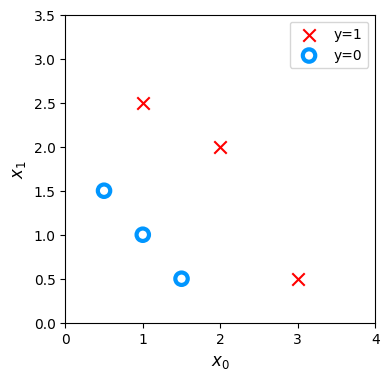

In [7]:
fig, ax = plt.subplots(1,1, figsize = (4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_xlabel('$x_0$', fontsize = 12)
ax.set_ylabel('$x_1$', fontsize = 12)
ax.plot()

In [8]:
def compute_gradient_logistic(X, y, w, b):

    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    return dj_db, dj_dw


Chechking the implementation.



In [9]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


The code below will repeat until the convergence, Find the points where the error is at it's least

In [10]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w, b, J_history         #return final w,b and J history for graphing


In [11]:
# Gradient Descent on our datasets

w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters)
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.684610468560574   
Iteration 1000: Cost 0.1590977666870457   
Iteration 2000: Cost 0.08460064176930078   
Iteration 3000: Cost 0.05705327279402531   
Iteration 4000: Cost 0.04290759421682   
Iteration 5000: Cost 0.03433847729884557   
Iteration 6000: Cost 0.02860379802212006   
Iteration 7000: Cost 0.02450156960879306   
Iteration 8000: Cost 0.02142370332569295   
Iteration 9000: Cost 0.019030137124109114   

updated parameters: w:[5.28123029 5.07815608], b:-14.222409982019837


Plotting the result of Gradient Descent

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [13]:
import matplotlib.cm as cm

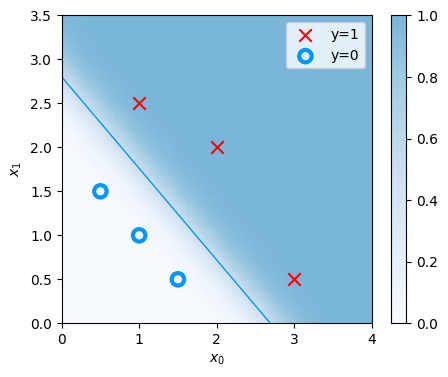

In [14]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c=dlc["dlblue"], lw=1)
plt.show()

In the plot above:

the shading reflects the probability y=1 (result prior to decision boundary)
the decision boundary is the line at which the probability = 0.5

**Another Data set**

In [15]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

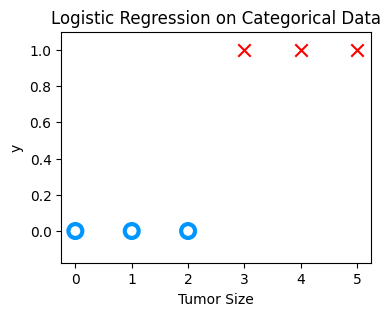

In [19]:
fig,ax = plt.subplots(1,1, figsize = (4,3))
plt_tumor_data(x_train, y_train, ax)

plt.show()

In [32]:
# pip install ipympl
%matplotlib widget
import matplotlib.gridspec as gridspec

In [34]:
w_range = np.array([-1, 7])
b_range = np.array([1, -14])
quad = plt_quad_logistic( x_train, y_train, w_range, b_range )